In [37]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(20200124)

In [38]:
def simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N):
    """
   generate similated data points

         X, y = simulations(pi, mu_1, mu_0, dim, sigma_1, sigma_0, N = 1000)

     Inputs:
             pi_1: prior probability for Y = 1
             mu_1, mu_0:   means for X|Y=1 and X|Y=0
             dim:   dimension of the feature space of X
             sigma_1, sigma_0: standard deviations for X|Y=1 and X|Y=0
             N: number of data points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # generate y from Bernolli(pi) as a vector with N entries
    y = np.random.binomial(1, pi_1, N)
    X = np.zeros([N, dim]) # initialize X
    num_1 = np.sum(y == 1)
    num_0 = np.sum(y == 0)
    X[y == 1] = np.random.multivariate_normal(mean = mu_1, cov = sigma_1, size = num_1)
    X[y == 0] = np.random.multivariate_normal(mean = mu_0, cov = sigma_0, size = num_0)
    return X, y

In [39]:
# import baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import (GridSearchCV,StratifiedKFold)
# scale and split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [40]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [41]:
def Bayes_proba(x, pi_1, mu_0, mu_1, Sigma):
    tmp = np.exp((mu_0[:,None] - mu_1[:,None]).T @ np.linalg.solve(Sigma, (x.T - (mu_0[:,None] + mu_1[:,None])/2)))
    return (pi_1/(pi_1 + (1 - pi_1) * tmp))[0,:]

In [42]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, accuracy_score
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))

In [73]:
def simulation_results(pi_1, mu, dim, N, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1: prior probability for Y = 1
             mu:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             N: number of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200124)
    mu_1 = np.zeros(dim,)
    mu_1[0] = mu
    mu_0 = np.zeros(dim,)
    mu_0[0] = -mu
    sigma_1 = np.identity(dim)
    sigma_0 = np.identity(dim)
    X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
    X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
    # class distribution
    train_ratio = y_train.sum()/len(y_train)
    test_ratio = y_test.sum()/len(y_test)
    print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
          'and',test_ratio,'for training and testing respectively.')
    """
    # scale and fit
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=444, stratify=y)
    """
    # compare different classifiers
    results_accuracy=[]
    results_auroc=[]
    results_average_precision=[]
    results_neg_log_loss=[]
    results_f1 = []
    results_recall =[]
    names=[]
    fpr_full = []
    tpr_full = []
    thresholds_roc_full = []
    precision_full = []
    recall_full = []
    thresholds_prc_full = []
    measures = ['AUROC','AUPRC','accuracy_best_threshold','accuracy','average_precision','f1','log_loss_score','recall']
    scores_table = np.zeros([9,8])
    roc_cut = np.zeros([8,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of each model
    prc_cut = np.zeros([8,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of each model
    i = 0 # looping index
    for name, model in models:
            y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            fpr_full = np.concatenate((fpr_full, fpr))
            tpr_full = np.concatenate((tpr_full, tpr))
            thresholds_roc_full = np.concatenate((thresholds_roc_full, thresholds))
            roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
            #Area under ROC curve
            auroc = roc_auc_score(y_test,y_pred_proba)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
            precision_full = np.concatenate((precision_full, precision))
            recall_full = np.concatenate((recall_full, recall))
            thresholds_prc_full = np.concatenate((thresholds_prc_full, thresholds))
            prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
            # area under PRC curve
            auprc = auc(recall, precision)
            
            threshold = Find_Optimal_Cutoff(y_test,y_pred_proba)
            y_pred = y_pred_proba>threshold
            accuracy_best_threshold = accuracy_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, model.predict(X_test))
            average_precision = average_precision_score(y_test, model.predict(X_test))
            f1 = f1_score(y_test, model.predict(X_test))
            log_loss_score = log_loss(y_test, model.predict(X_test))
            recall = recall_score(y_test, model.predict(X_test))
            names.append(name)


            # report of scores
            scores_table[i, 0] = auroc
            scores_table[i, 1] = auprc
            scores_table[i, 2] = accuracy_best_threshold
            scores_table[i, 3] = accuracy
            scores_table[i, 4] = average_precision
            scores_table[i, 5] = f1
            scores_table[i, 6] = -log_loss_score
            scores_table[i, 7] = recall
            print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, average precision = {:.3f}, '.format(auroc,auprc,average_precision),
                  '. \nBest threshold for ROC = {:.3f},'.format(threshold[0]), 'accuracy for the best ROC threshold is then {:.3f},'
                  .format(accuracy_best_threshold),'accuracy = {:.3f}.'.format(accuracy),
                  '\nF1 score = {:.3f},'.format(f1), 'log loss = {:.3f},'.format(log_loss_score),'recall = {:.3f}.'.format(recall))
            print ("--"*30)
            i = i + 1
    
    # Bayes classifier
    y_pred_prob_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    #Area under ROC curve
    auroc = roc_auc_score(y_test,y_pred_prob_Bayes)
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred_prob_Bayes)
    auprc = auc(recall, precision)
    print('Bayes classifier has AUROC = {:.3f},and AUPRC = {:.3f}.'.format(auroc, auprc))
    scores_table[7, 0] = auroc # Bayes
    scores_table[7, 1] = auprc # Bayes
    scores_table[8, 0] = 0.5 # random guess
    scores_table[8, 1] = test_ratio # random guess   
    #plot ROC
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr)
    for i in range(7):
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'pi_1' + str(pi_1) + '_mu' + str(mu) + '_N' + str(N) + '_dim' + str(dim) + ' ROC curve'
    plt.title(title_name)
    plt.legend(['random guess','Bayes','LR', 'LDA','KNN','CART','NB','RF','AdaBoost'])
    save_name = 'pi_1' + str(pi_1) + '_mu' + str(mu) + '_N' + str(N) + '_dim' + str(dim) + ' simulation ROC curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    plt.axhline(y=test_ratio, xmin=0, xmax=1,color='k', linestyle = '--')
    plt.plot(recall,precision, label=name)
    for i in range(7):
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'pi_1' + str(pi_1) + '_mu' + str(mu) + '_N' + str(N) + '_dim' + str(dim) + ' PRC curve'
    plt.title(title_name)
    plt.legend(['random guess','Bayes','LR', 'LDA','KNN','CART','NB','RF','AdaBoost'])
    save_name = 'pi_1' + str(pi_1) + '_mu' + str(mu) + '_N' + str(N) + '_dim' + str(dim) + ' simulation PRC curve.png'
    plt.savefig(save_name)
    plt.show()
    
    for i in range(8):
        print('The best model measured by ',measures[i],'is ',names[np.argmax(scores_table[:7,i])]) 
    print ("--"*30)
    print ("--"*30)
    csv_name = 'Simulation with pi_1' + str(pi_1) + '_mu' + str(mu) + '_N' + str(N) + '_dim' + str(dim) + '.csv'
    np.savetxt(csv_name, scores_table, delimiter=",")

Positive ratios for pi_1 = 0.5 , mu = 1 , dim = 5  are 0.56 and 0.501 for training and testing respectively.
LR : AUROC = 0.920, AUPRC = 0.925, average precision = 0.760,  . 
Best threshold for ROC = 0.602, accuracy for the best ROC threshold is then 0.827, accuracy = 0.825. 
F1 score = 0.833, log loss = 6.044, recall = 0.870.
------------------------------------------------------------
LDA : AUROC = 0.918, AUPRC = 0.924, average precision = 0.769,  . 
Best threshold for ROC = 0.547, accuracy for the best ROC threshold is then 0.825, accuracy = 0.830. 
F1 score = 0.834, log loss = 5.872, recall = 0.854.
------------------------------------------------------------
KNN : AUROC = 0.883, AUPRC = 0.890, average precision = 0.765,  . 
Best threshold for ROC = 0.600, accuracy for the best ROC threshold is then 0.806, accuracy = 0.824. 
F1 score = 0.826, log loss = 6.079, recall = 0.834.
------------------------------------------------------------
CART : AUROC = 0.815, AUPRC = 0.860, average p

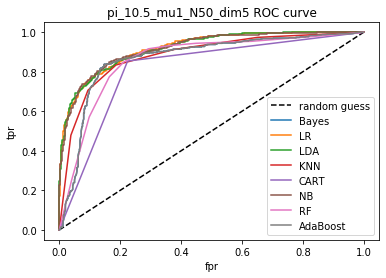

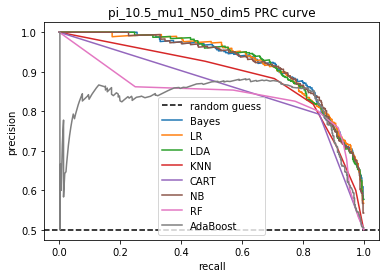

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  AdaBoost
The best model measured by  accuracy is  NB
The best model measured by  average_precision is  AdaBoost
The best model measured by  f1 is  NB
The best model measured by  log_loss_score is  AdaBoost
The best model measured by  recall is  RF
------------------------------------------------------------
------------------------------------------------------------


In [74]:
# can tune parameters here and see different results
simulation_results(pi_1 = 0.5, mu = 1, dim = 5, N = 50, N_test = 1000)

Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.56 and 0.501 for training and testing respectively.
LR : AUROC = 0.750, AUPRC = 0.752, average precision = 0.626,  . 
Best threshold for ROC = 0.590, accuracy for the best ROC threshold is then 0.687, accuracy = 0.689. 
F1 score = 0.711, log loss = 10.742, recall = 0.762.
------------------------------------------------------------
LDA : AUROC = 0.751, AUPRC = 0.754, average precision = 0.625,  . 
Best threshold for ROC = 0.581, accuracy for the best ROC threshold is then 0.693, accuracy = 0.686. 
F1 score = 0.704, log loss = 10.845, recall = 0.747.
------------------------------------------------------------
KNN : AUROC = 0.696, AUPRC = 0.711, average precision = 0.601,  . 
Best threshold for ROC = 0.600, accuracy for the best ROC threshold is then 0.627, accuracy = 0.655. 
F1 score = 0.664, log loss = 11.916, recall = 0.681.
------------------------------------------------------------
CART : AUROC = 0.621, AUPRC = 0.726, aver

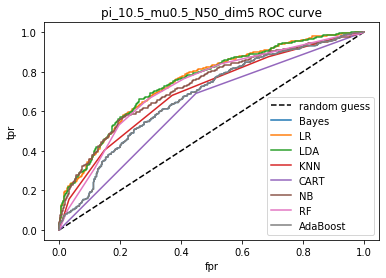

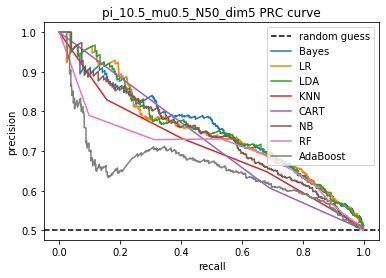

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  LDA
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  LR
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  RF
------------------------------------------------------------
------------------------------------------------------------


In [75]:
simulation_results(pi_1 = 0.5, mu = 0.5, dim = 5, N = 50, N_test = 1000)

Positive ratios for pi_1 = 0.1 , mu = 0.5 , dim = 5  are 0.16 and 0.098 for training and testing respectively.
LR : AUROC = 0.667, AUPRC = 0.206, average precision = 0.139,  . 
Best threshold for ROC = 0.206, accuracy for the best ROC threshold is then 0.603, accuracy = 0.871. 
F1 score = 0.246, log loss = 4.456, recall = 0.214.
------------------------------------------------------------
LDA : AUROC = 0.659, AUPRC = 0.198, average precision = 0.140,  . 
Best threshold for ROC = 0.155, accuracy for the best ROC threshold is then 0.578, accuracy = 0.880. 
F1 score = 0.241, log loss = 4.145, recall = 0.194.
------------------------------------------------------------
KNN : AUROC = 0.585, AUPRC = 0.113, average precision = 0.098,  . 
Best threshold for ROC = 0.200, accuracy for the best ROC threshold is then 0.799, accuracy = 0.894. 
F1 score = 0.000, log loss = 3.661, recall = 0.000.
------------------------------------------------------------
CART : AUROC = 0.567, AUPRC = 0.284, average

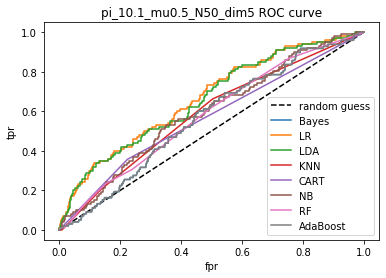

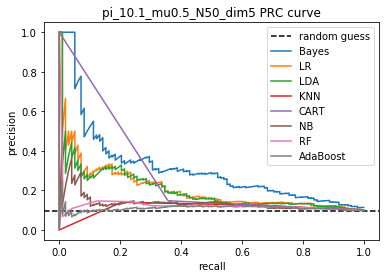

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  CART
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  KNN
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  KNN
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.1 , mu = 0.5 , dim = 5  are 0.122 and 0.091 for training and testing respectively.
LR : AUROC = 0.774, AUPRC = 0.236, average precision = 0.112,  . 
Best threshold for ROC = 0.130, accuracy for the best ROC threshold is then 0.709, accuracy = 0.910. 
F1 score = 0.082, log loss = 3.108, recall = 0.044.
------------------------------------------------------------
LDA : AUROC = 0.769, AUPRC = 0.229, average precision = 0.102,  . 
Best threshold for ROC = 0.123, accuracy 

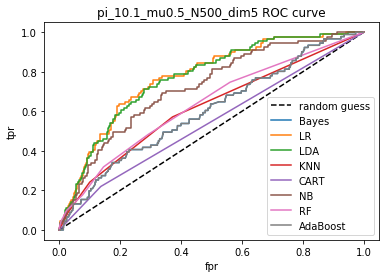

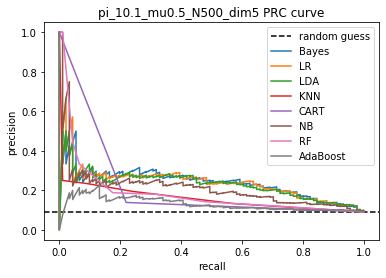

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  NB
The best model measured by  average_precision is  NB
The best model measured by  f1 is  CART
The best model measured by  log_loss_score is  NB
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.1 , mu = 0.5 , dim = 5  are 0.0982 and 0.09 for training and testing respectively.
LR : AUROC = 0.741, AUPRC = 0.274, average precision = 0.120,  . 
Best threshold for ROC = 0.087, accuracy for the best ROC threshold is then 0.685, accuracy = 0.912. 
F1 score = 0.102, log loss = 3.039, recall = 0.056.
------------------------------------------------------------
LDA : AUROC = 0.741, AUPRC = 0.274, average precision = 0.120,  . 
Best threshold for ROC = 0.086, accuracy for

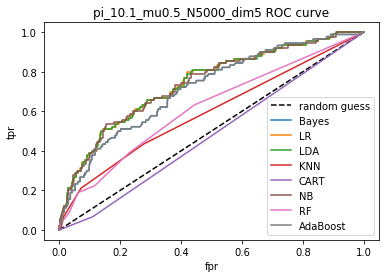

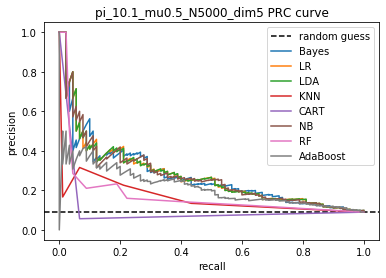

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  LR
The best model measured by  f1 is  KNN
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  KNN
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 0.5 , dim = 5  are 0.16 and 0.193 for training and testing respectively.
LR : AUROC = 0.684, AUPRC = 0.355, average precision = 0.246,  . 
Best threshold for ROC = 0.216, accuracy for the best ROC threshold is then 0.623, accuracy = 0.799. 
F1 score = 0.280, log loss = 6.942, recall = 0.202.
------------------------------------------------------------
LDA : AUROC = 0.676, AUPRC = 0.339, average precision = 0.252,  . 
Best threshold for ROC = 0.164, accuracy for t

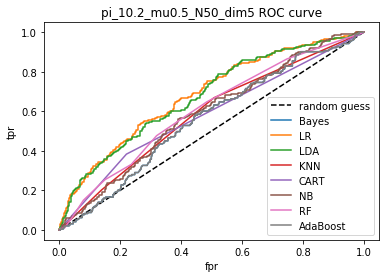

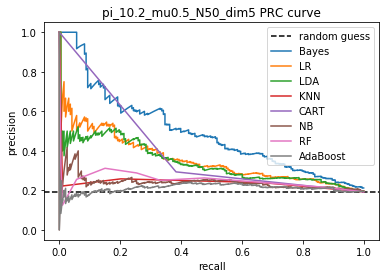

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  CART
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  LDA
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  CART
The best model measured by  log_loss_score is  LDA
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 0.5 , dim = 5  are 0.204 and 0.191 for training and testing respectively.
LR : AUROC = 0.779, AUPRC = 0.453, average precision = 0.258,  . 
Best threshold for ROC = 0.213, accuracy for the best ROC threshold is then 0.732, accuracy = 0.817. 
F1 score = 0.271, log loss = 6.321, recall = 0.178.
------------------------------------------------------------
LDA : AUROC = 0.779, AUPRC = 0.450, average precision = 0.248,  . 
Best threshold for ROC = 0.211, accurac

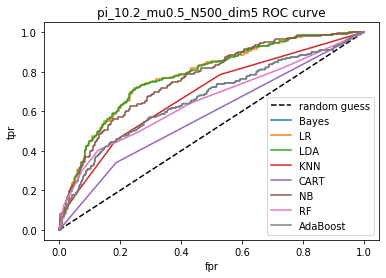

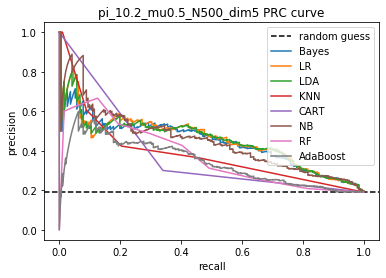

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  NB
The best model measured by  average_precision is  RF
The best model measured by  f1 is  CART
The best model measured by  log_loss_score is  NB
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 0.5 , dim = 5  are 0.1918 and 0.184 for training and testing respectively.
LR : AUROC = 0.765, AUPRC = 0.479, average precision = 0.267,  . 
Best threshold for ROC = 0.181, accuracy for the best ROC threshold is then 0.704, accuracy = 0.831. 
F1 score = 0.281, log loss = 5.837, recall = 0.179.
------------------------------------------------------------
LDA : AUROC = 0.765, AUPRC = 0.479, average precision = 0.271,  . 
Best threshold for ROC = 0.180, accuracy fo

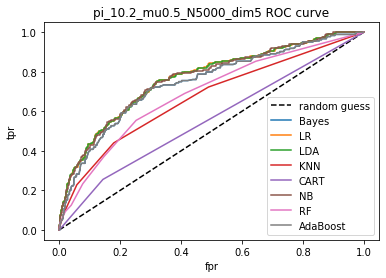

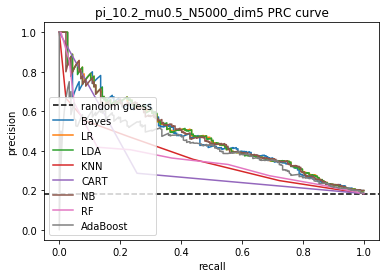

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  LDA
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  KNN
The best model measured by  log_loss_score is  LDA
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 0.5 , dim = 5  are 0.36 and 0.312 for training and testing respectively.
LR : AUROC = 0.734, AUPRC = 0.569, average precision = 0.428,  . 
Best threshold for ROC = 0.386, accuracy for the best ROC threshold is then 0.669, accuracy = 0.703. 
F1 score = 0.537, log loss = 10.258, recall = 0.551.
------------------------------------------------------------
LDA : AUROC = 0.735, AUPRC = 0.571, average precision = 0.431,  . 
Best threshold for ROC = 0.329, accuracy f

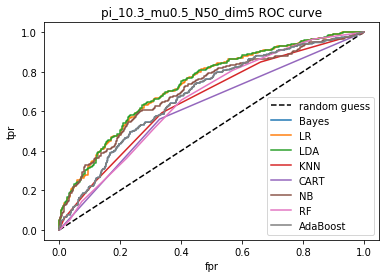

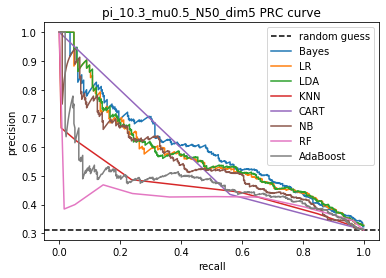

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  CART
The best model measured by  accuracy is  LDA
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LDA
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 0.5 , dim = 5  are 0.346 and 0.296 for training and testing respectively.
LR : AUROC = 0.773, AUPRC = 0.580, average precision = 0.441,  . 
Best threshold for ROC = 0.350, accuracy for the best ROC threshold is then 0.708, accuracy = 0.761. 
F1 score = 0.499, log loss = 8.255, recall = 0.402.
------------------------------------------------------------
LDA : AUROC = 0.772, AUPRC = 0.577, average precision = 0.431,  . 
Best threshold for ROC = 0.349, accuracy 

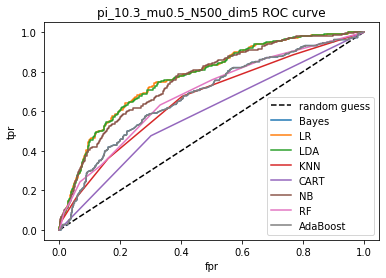

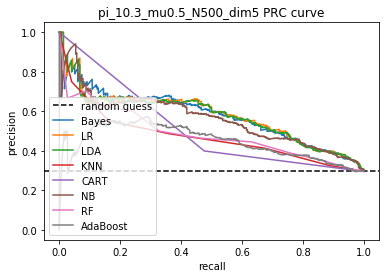

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  LR
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  LR
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 0.5 , dim = 5  are 0.2974 and 0.279 for training and testing respectively.
LR : AUROC = 0.771, AUPRC = 0.578, average precision = 0.398,  . 
Best threshold for ROC = 0.293, accuracy for the best ROC threshold is then 0.715, accuracy = 0.760. 
F1 score = 0.439, log loss = 8.289, recall = 0.337.
------------------------------------------------------------
LDA : AUROC = 0.771, AUPRC = 0.578, average precision = 0.395,  . 
Best threshold for ROC = 0.292, accuracy for th

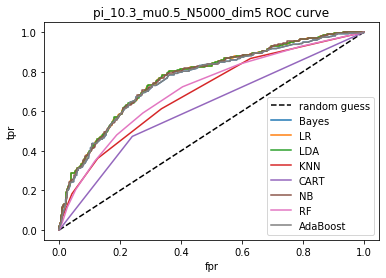

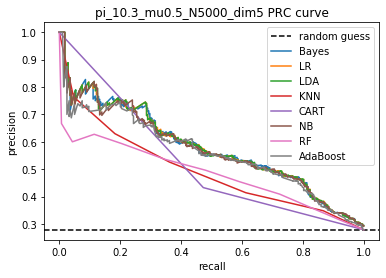

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  KNN
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  NB
The best model measured by  f1 is  AdaBoost
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  CART
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.46 and 0.405 for training and testing respectively.
LR : AUROC = 0.740, AUPRC = 0.665, average precision = 0.542,  . 
Best threshold for ROC = 0.520, accuracy for the best ROC threshold is then 0.690, accuracy = 0.689. 
F1 score = 0.648, log loss = 10.742, recall = 0.706.
------------------------------------------------------------
LDA : AUROC = 0.741, AUPRC = 0.664, average precision = 0.543,  . 
Best threshold for ROC = 0.483, accuracy

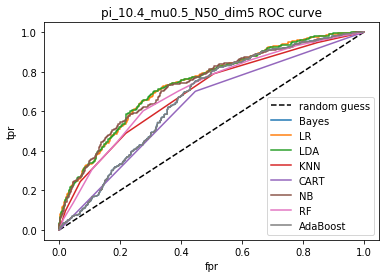

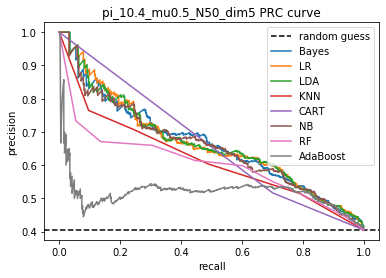

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  CART
The best model measured by  accuracy_best_threshold is  LDA
The best model measured by  accuracy is  LDA
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LDA
The best model measured by  recall is  LR
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.44 and 0.398 for training and testing respectively.
LR : AUROC = 0.783, AUPRC = 0.694, average precision = 0.573,  . 
Best threshold for ROC = 0.434, accuracy for the best ROC threshold is then 0.711, accuracy = 0.733. 
F1 score = 0.644, log loss = 9.222, recall = 0.608.
------------------------------------------------------------
LDA : AUROC = 0.783, AUPRC = 0.693, average precision = 0.574,  . 
Best threshold for ROC = 0.435, accuracy for

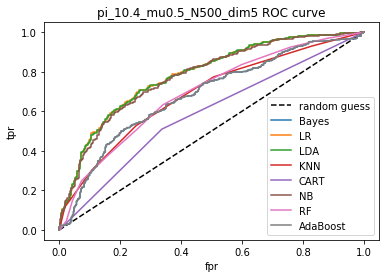

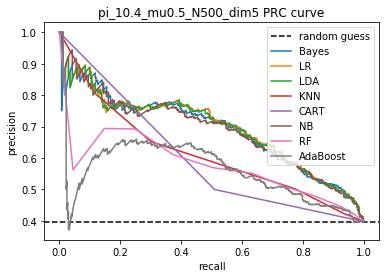

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy_best_threshold is  LDA
The best model measured by  accuracy is  LDA
The best model measured by  average_precision is  LDA
The best model measured by  f1 is  LDA
The best model measured by  log_loss_score is  LDA
The best model measured by  recall is  LR
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.4004 and 0.398 for training and testing respectively.
LR : AUROC = 0.765, AUPRC = 0.675, average precision = 0.537,  . 
Best threshold for ROC = 0.397, accuracy for the best ROC threshold is then 0.711, accuracy = 0.706. 
F1 score = 0.575, log loss = 10.154, recall = 0.500.
------------------------------------------------------------
LDA : AUROC = 0.765, AUPRC = 0.675, average precision = 0.537,  . 
Best threshold for ROC = 0.396, accuracy fo

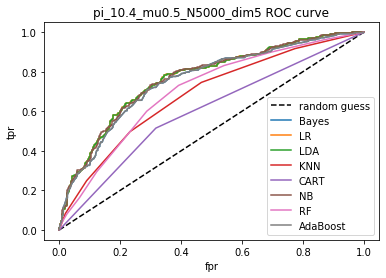

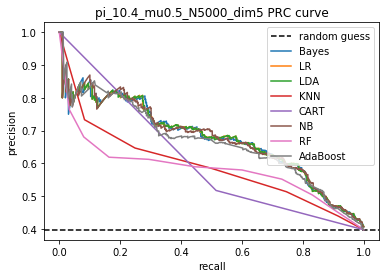

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  LR
The best model measured by  accuracy is  NB
The best model measured by  average_precision is  AdaBoost
The best model measured by  f1 is  AdaBoost
The best model measured by  log_loss_score is  NB
The best model measured by  recall is  AdaBoost
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.56 and 0.501 for training and testing respectively.
LR : AUROC = 0.750, AUPRC = 0.752, average precision = 0.626,  . 
Best threshold for ROC = 0.590, accuracy for the best ROC threshold is then 0.687, accuracy = 0.689. 
F1 score = 0.711, log loss = 10.742, recall = 0.762.
------------------------------------------------------------
LDA : AUROC = 0.751, AUPRC = 0.754, average precision = 0.625,  . 
Best threshold for ROC = 0.581,

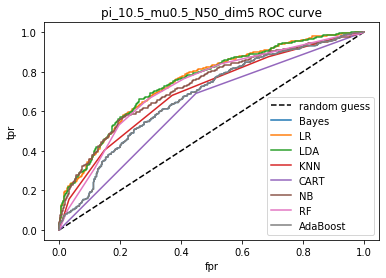

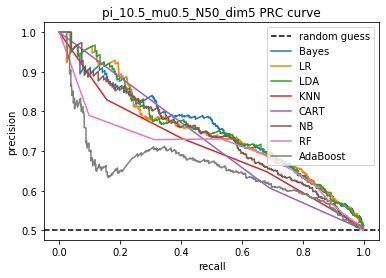

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy_best_threshold is  LDA
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  LR
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  RF
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.554 and 0.502 for training and testing respectively.
LR : AUROC = 0.777, AUPRC = 0.761, average precision = 0.633,  . 
Best threshold for ROC = 0.544, accuracy for the best ROC threshold is then 0.706, accuracy = 0.696. 
F1 score = 0.716, log loss = 10.500, recall = 0.765.
------------------------------------------------------------
LDA : AUROC = 0.777, AUPRC = 0.762, average precision = 0.633,  . 
Best threshold for ROC = 0.544, accuracy for t

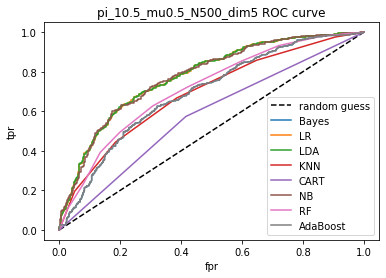

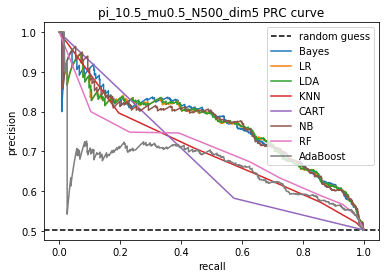

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  NB
The best model measured by  accuracy_best_threshold is  NB
The best model measured by  accuracy is  NB
The best model measured by  average_precision is  NB
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  NB
The best model measured by  recall is  LR
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.5048 and 0.521 for training and testing respectively.
LR : AUROC = 0.778, AUPRC = 0.785, average precision = 0.677,  . 
Best threshold for ROC = 0.499, accuracy for the best ROC threshold is then 0.720, accuracy = 0.720. 
F1 score = 0.728, log loss = 9.671, recall = 0.718.
------------------------------------------------------------
LDA : AUROC = 0.778, AUPRC = 0.785, average precision = 0.676,  . 
Best threshold for ROC = 0.497, accuracy for the

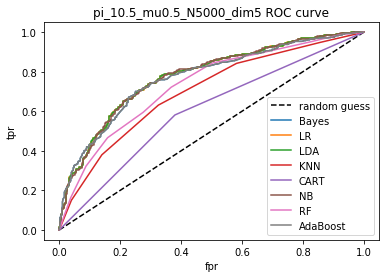

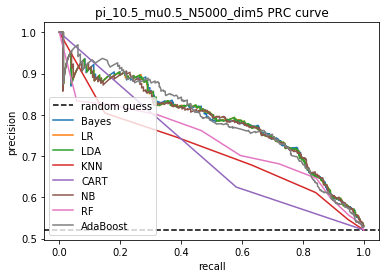

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  AdaBoost
The best model measured by  accuracy_best_threshold is  LR
The best model measured by  accuracy is  LR
The best model measured by  average_precision is  LR
The best model measured by  f1 is  LR
The best model measured by  log_loss_score is  LR
The best model measured by  recall is  AdaBoost
------------------------------------------------------------
------------------------------------------------------------


In [76]:
# can tune parameters here and see different results
for pi_1 in [0.1,0.2,0.3,0.4,0.5]:
    for N_train in [50, 500, 5000]:
        simulation_results(pi_1, mu = 0.5, dim = 5, N = N_train, N_test = 1000)